# 잘못 분류된 label 고치기

In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/opt/ml/image-classification-level1-04/EDA'

In [3]:
class cfg:
    data_dir = '/opt/ml/input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [4]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


## 방법 1. 잘못된 데이터셋을 고친 새로운 데이터셋 생성[보류]

In [194]:
# 잘못 분류된 데이터 샘플
incorrect_labels = {'error_in_female' : ['006359', '006360', '006361', '006362', '006363', '006364'],
                    'error_in_male' : ['001498-1', '004432'],
                    'swap_normal_incorrect' : ['000020', '004418', '005227']}

```python
for idx in incorrect_labels['error_in_female']:
    df[df.id == idx]['gender'] = 'male'

for idx in incorrect_labels['error_in_male']:
    df[df.id == idx]['gender'] = 'female'
```

Mask의 경우 filename을 rename해야함  
-> 처리 보류
```python
for idx in incorrect_labels['swap_normal_incorrect']:
    original_path = df[(df.id == idx) & ('incorrect' in df.path)]['path']
    os.rename(original_path, '바꿀 파일 이름')
```

## 방법 2. 잘못된 데이터셋은 그대로 두고 데이터셋 클래스에서 불러올 때, 잘못 분류된 label을 고치는 방법
```python
# 210826 수정
# image-calssification-level-01-04/dataloader/datasets.py
class MaskDataset(Dataset):
    """
    dir_path: "../input/data/train"
    csv_path: original train.csv path
    """
    def __init__(self, csv_path, transform=None):
        super().__init__()
        self.transform = transform
        self.dir_path = os.path.dirname(csv_path)
        self.csv_path = csv_path
        self.img_dir_path = os.path.join(self.dir_path, 'images')
        self.trans_csv_path = os.path.join(self.dir_path, 'trans_train_v4.csv')
        self.incorrect_labels = {'error_in_female' : ['006359', '006360', '006361', '006362', '006363', '006364'],
                                'error_in_male' : ['001498-1', '004432'],
                                'swap_normal_incorrect' : ['000020', '004418', '005227']}
        # if preprocessed trainV4.csv file doesnt' exists,
        # preprocess train.csv -> trainV4.csv
        if os.path.exists(self.trans_csv_path):
            pass
        else:
            self._makeCSV()

        self.df = pd.read_csv(self.trans_csv_path).values
        self.class_weights = self._get_class_weight()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        sample = self.df[index]
        label = sample[-1]
        image = PIL.Image.open(sample[-2])
        image = np.array(image.convert("RGB"))
        if self.transform is not None:
            #image = self.transform(image)
            transformed = self.transform(image=image)
            image = transformed['image']
        return image, torch.tensor(label)

    def _makeCSV(self):
        df = pd.read_csv(self.csv_path)
        with open(self.trans_csv_path, 'wt', newline='') as csvfile:
            maskwriter = csv.writer(csvfile)
            maskwriter.writerow(["gender", "race", "age", "path", "label"])
            for index in range(len(df)) : 
                data = df.iloc[index]

                img_path_base = os.path.join(os.path.join(self.img_dir_path, data['path']), '*')
                for img_path in glob.glob(img_path_base):
                    # labeling
                    label = 0
                    if "incorrect" in img_path:
                        label+=6
                    elif "normal" in img_path:
                        label+=12
                    if data["gender"] =="female":
                        label+=3
                    if data["age"] >= 60 :
                        label+=2
                    elif data["age"] >=30 and data["age"] < 60:
                        label+=1          
                    
                    # incorrect label fix
                    ## 1. female -> male
                    if data['id'] in self.incorrect_labels['error_in_female']:
                        label-=3
                    ## 2. male -> female
                    if data['id'] in self.incorrect_labels['error_in_male']:
                        label+=3
                    ## 3. mask <-> incorrect
                    if "incorrect" in img_path and data['id'] in self.incorrect_labels['swap_normal_incorrect']:
                        label+=6
                    if "normal" in img_path and data['id'] in self.incorrect_labels['swap_normal_incorrect']:
                        label-=6

                    maskwriter.writerow([data["gender"], data["race"], data["age"], img_path, label])

    def _get_class_weight(self):
        class_weights = dict(enumerate(class_weight.compute_class_weight('balanced',
                            classes=np.sort(np.unique(self.df[:, -1])), # label
                            y=self.df[:, -1])))
        return torch.tensor(list(class_weights.values()), dtype=torch.float)
```

제대로 분류 되었는지 확인

In [179]:
df_incorrect_fix = pd.read_csv(os.path.join(cfg.data_dir, 'trans_train_v4.csv'))

In [180]:
# 각 label이 모두 존재하는지 확인
df_incorrect_fix.label.unique()

array([ 4, 10, 16,  1,  7, 13,  3,  9, 15,  0,  6, 12,  2,  8, 14,  5, 11,
       17])

In [191]:
# 잘못 분류된 label list 추출
incorrect_labels = {'error_in_female' : ['006359', '006360', '006361', '006362', '006363', '006364'],
                    'error_in_male' : ['001498-1', '004432'],
                    'swap_normal_incorrect' : ['000020', '004418', '005227']}
incorrect_labels = [i for lst in incorrect_labels.values() for i in lst]
incorrect_labels

['006359',
 '006360',
 '006361',
 '006362',
 '006363',
 '006364',
 '001498-1',
 '004432',
 '000020',
 '004418',
 '005227']

잘못 분류된 것들만 모아 데이터셋 구성, 각각의 이미지 확인

In [192]:
def check(path):
    for i in incorrect_labels:
        if i in path:
            return True
    return False

df_incorrect = df_incorrect_fix[df_incorrect_fix.path.apply(check)]
df_incorrect

,gender,race,age,path,label
105,female,Asian,50,../input/data/train/images/000020_female_Asian...,4
106,female,Asian,50,../input/data/train/images/000020_female_Asian...,4
107,female,Asian,50,../input/data/train/images/000020_female_Asian...,4
108,female,Asian,50,../input/data/train/images/000020_female_Asian...,4
109,female,Asian,50,../input/data/train/images/000020_female_Asian...,4
...,...,...,...,...,...
16830,female,Asian,18,../input/data/train/images/006364_female_Asian...,0
16831,female,Asian,18,../input/data/train/images/006364_female_Asian...,0
16832,female,Asian,18,../input/data/train/images/006364_female_Asian...,0
16833,female,Asian,18,../input/data/train/images/006364_female_Asian...,6


In [193]:
imgs = []
paths = df_incorrect.path
ext = get_ext(cfg.img_dir, img_id)
for path in paths:
    img = np.array(Image.open('/opt/ml' + path[2:]))
    imgs.append(img)
imgs = np.array(imgs)

성별 및 마스크 착용여부가 수정된 것을 확인

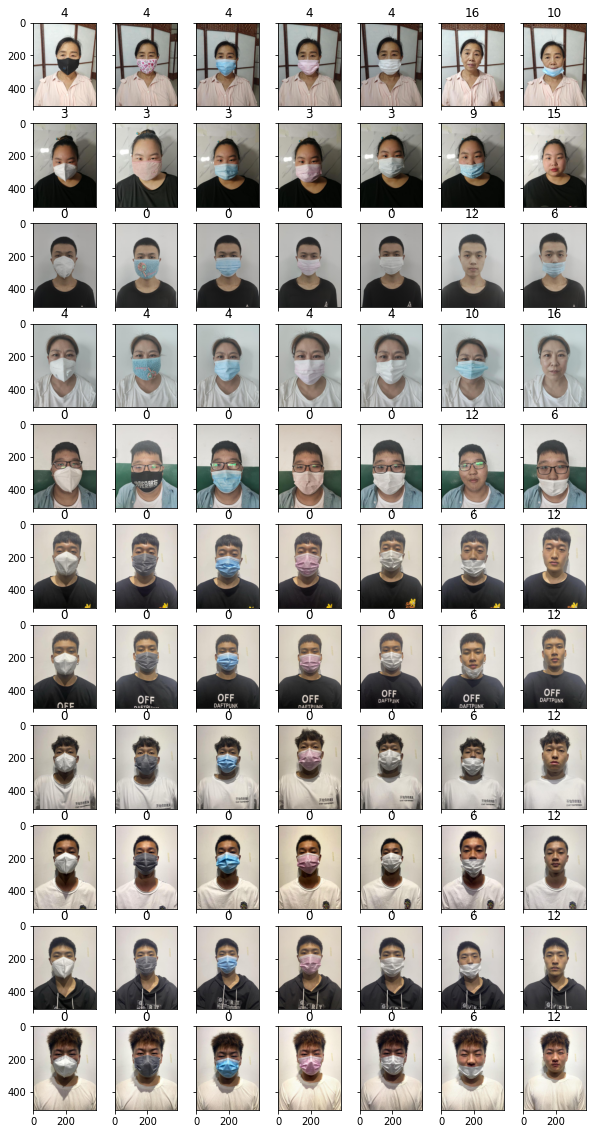

In [ ]:
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10, 20))

i = 0
for r in range(11):
    for c in range(7):
        axes[r][c].imshow(imgs[i])
        axes[r][c].set_title(df_incorrect.label.iloc[i])
        i += 1
plt.show()